# 1. Project Overview


The E-commerce Dataset provides comprehensive data for analyzing online retail behavior. It includes customer demographics, product details, purchase history, and shipping information. Key features include customer IDs, genders, regions, product categories, prices, quantities, total prices, and shipping statuses. This dataset is ideal for building machine learning models such as recommender systems, customer segmentation using clustering techniques like KMeans or DBSCAN, and sales trend analysis. Researchers and data enthusiasts can explore insights into purchasing patterns and demographic preferences. Additionally, the dataset can be used for predictive analytics, such as predicting customer churn or identifying high-value customers.

### Goals of the Unsupervised Clustering Model 

1. Customer Segmentation:Group customers based on purchasing behavior, demographics, or preferences.Example: Identify high-spenders, budget-conscious buyers, or frequent purchasers.23. Product Segmentation:Group products by their attributes, purchase frequency, or popularity.Example: Categorize products as luxury, trending, or essentials3
4. Market Strategy Optimization:Create targeted marketing campaigns for different customer or product groups.Example: Recommend similar products to customers in specific clusters4
5. Pattern Discovery:Uncover hidden structures or correlations in the data.Example: Find geographic or seasonal purchasing trend5.
6. Data Reduction:Simplify high-dimensional datasets using techniques like PCA before clustering.Example: Retain key information while making clustering efficient.tion.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pathlib import Path
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import  GridSearchCV,cross_val_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Data sources;
https://www.kaggle.com/datasets/brsahan/e-commerce-dataset 

In [2]:
data_path = "/kaggle/input/e-commerce-dataset/realistic_e_commerce_sales_data.csv"
data = pd.read_csv(data_path)

# Step 2: EDA
print("Dataset Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer ID      1000 non-null   object 
 1   Gender           1000 non-null   object 
 2   Region           950 non-null    object 
 3   Age              900 non-null    float64
 4   Product Name     1000 non-null   object 
 5   Category         1000 non-null   object 
 6   Unit Price       1000 non-null   float64
 7   Quantity         1000 non-null   int64  
 8   Total Price      1000 non-null   int64  
 9   Shipping Fee     1000 non-null   float64
 10  Shipping Status  950 non-null    object 
 11  Order Date       1000 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 93.9+ KB
None

Summary Statistics:
              Age   Unit Price     Quantity  Total Price  Shipping Fee
count  900.000000  1000.000000  1000.000000  1000.000000   1000.000000
mean 

This dataset contains information on 1,000 e-commerce transactions, covering 12 columns. It includes customer demographics (e.g., age, gender, and region), product details (e.g., product name, category, and unit price), and transactional data (e.g., quantity, total price, shipping fee, and shipping status). The data is well-structured, with no missing values, making it suitable for unsupervised learning tasks like clustering (e.g., customer segmentation) or dimensionality reduction (e.g., PCA).

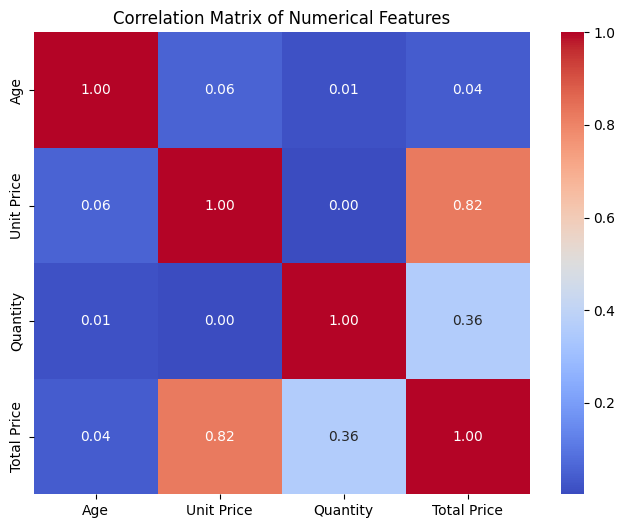

In [3]:
correlation_matrix = data[['Age', 'Unit Price', 'Quantity', 'Total Price']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The correlation matrix visualizes relationships among numerical features in the dataset, including **Age**, **Unit Price**, **Quantity**, and **Total Price**. Key insights reveal a strong positive correlation between **Unit Price** and **Total Price** (0.82), indicating that higher-priced items contribute more to transaction totals. A moderate positive correlation exists between **Quantity** and **Total Price** (0.36), showing that larger purchases increase transaction value. **Age** has negligible correlation with other features, suggesting minimal influence on pricing or purchase behavior. This analysis is valuable for understanding feature interactions, supporting dimensionality reduction, and improving unsupervised learning models like clustering or recommendation systems.

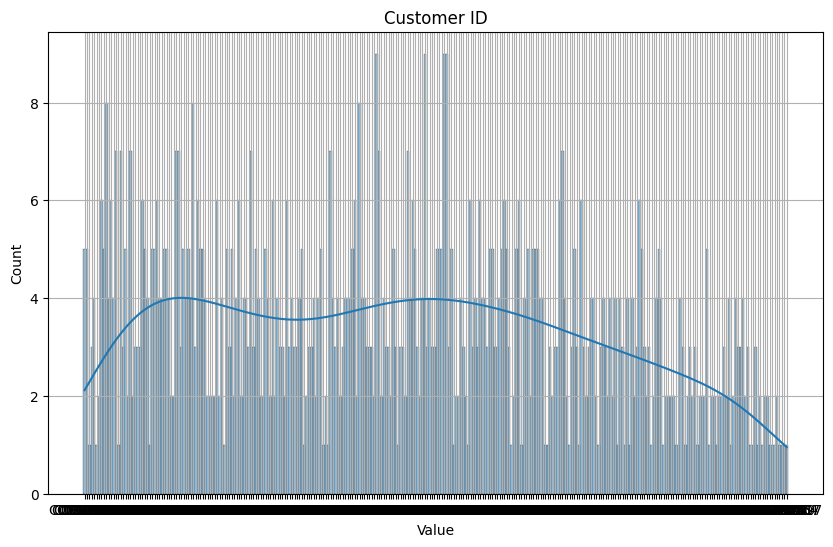

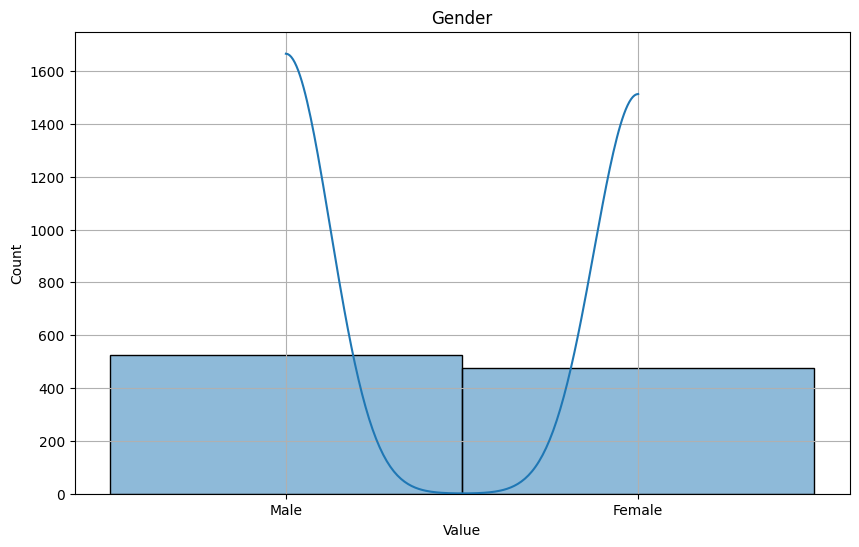

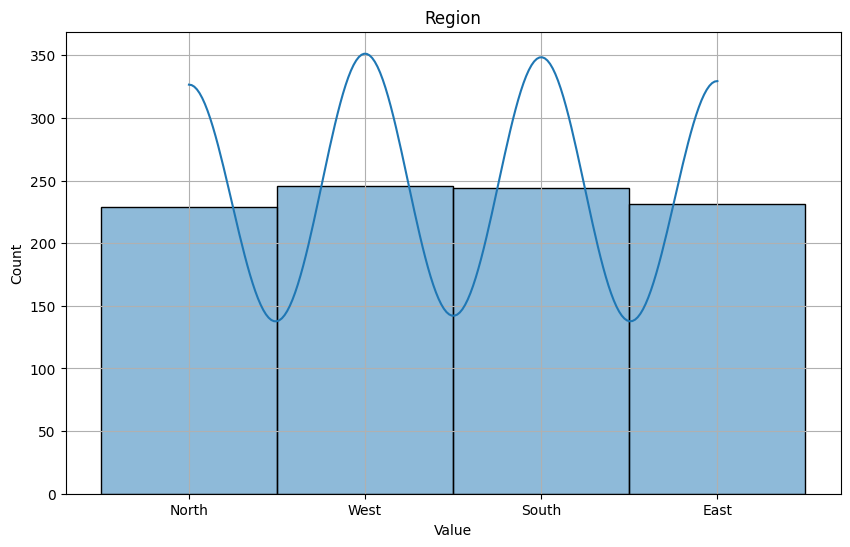

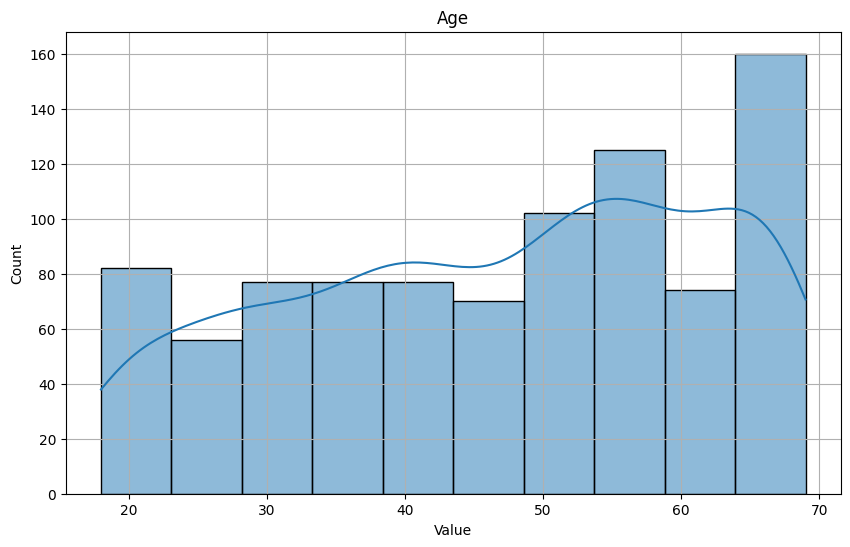

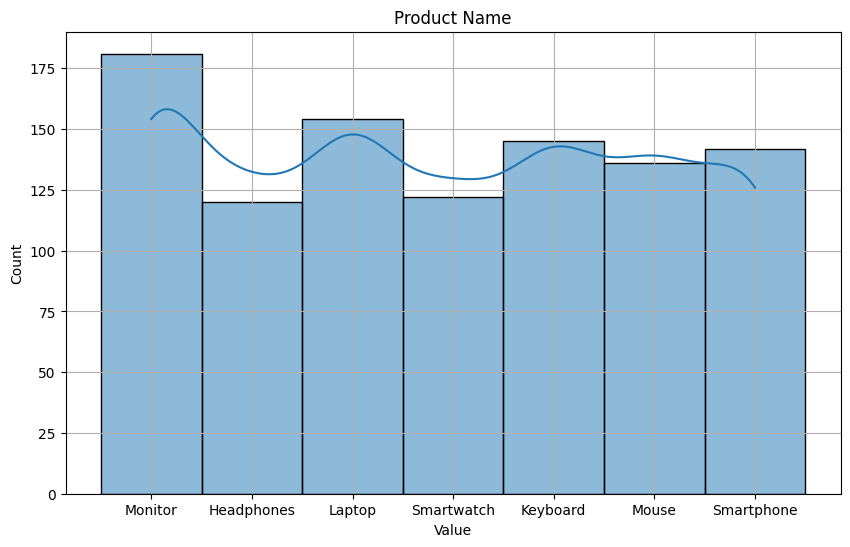

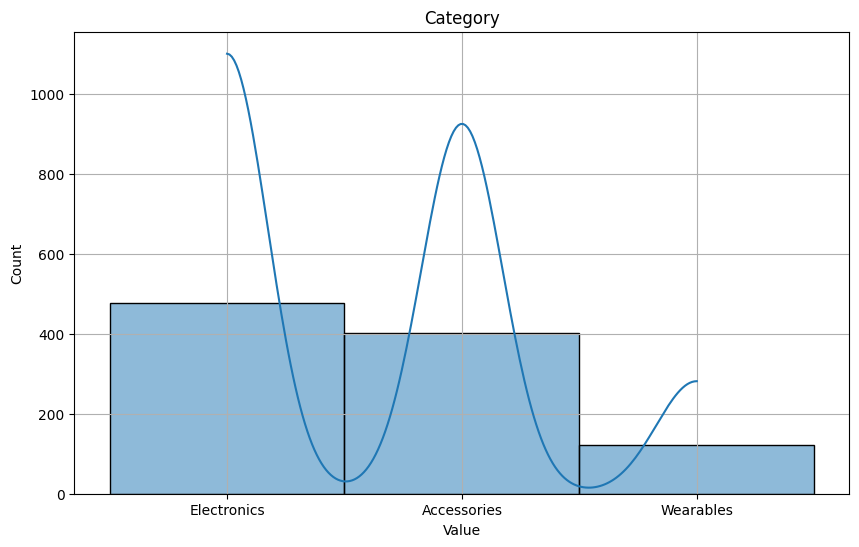

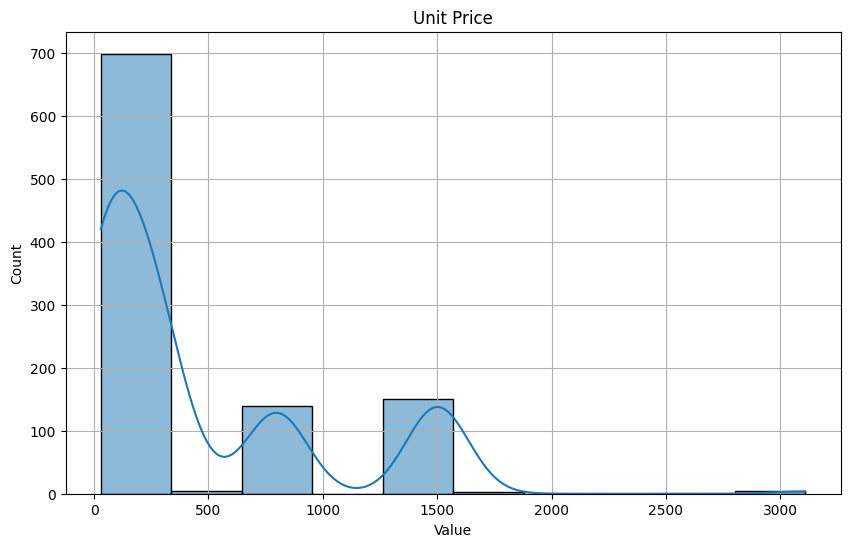

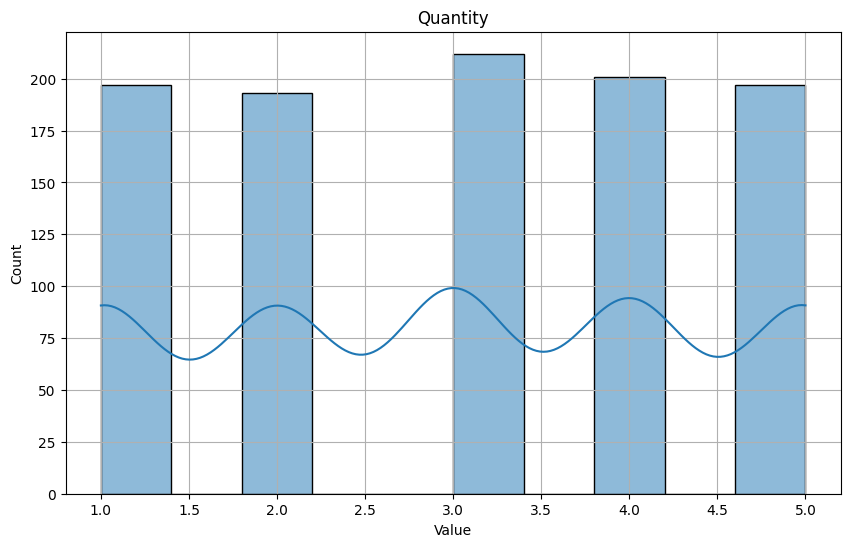

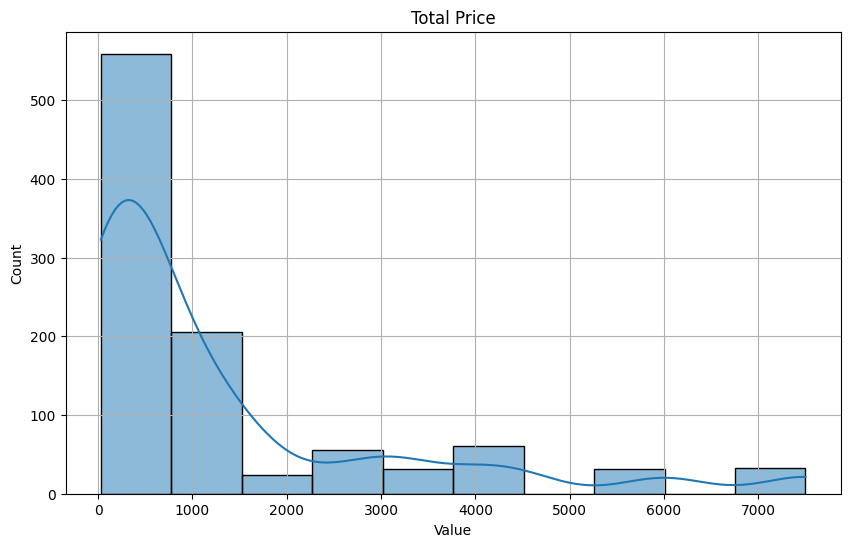

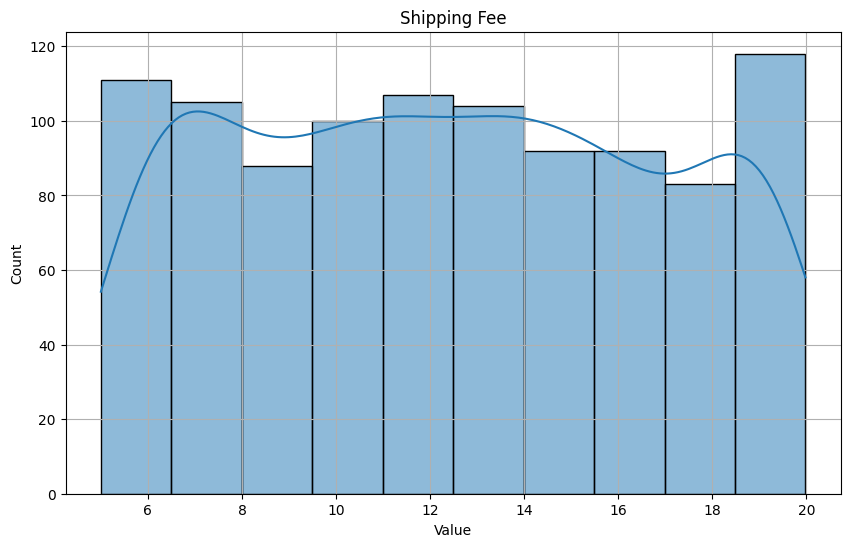

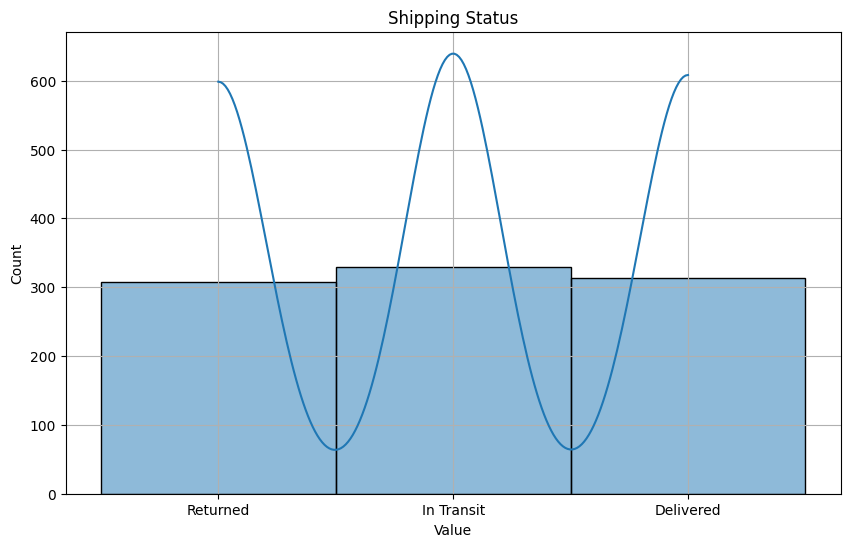

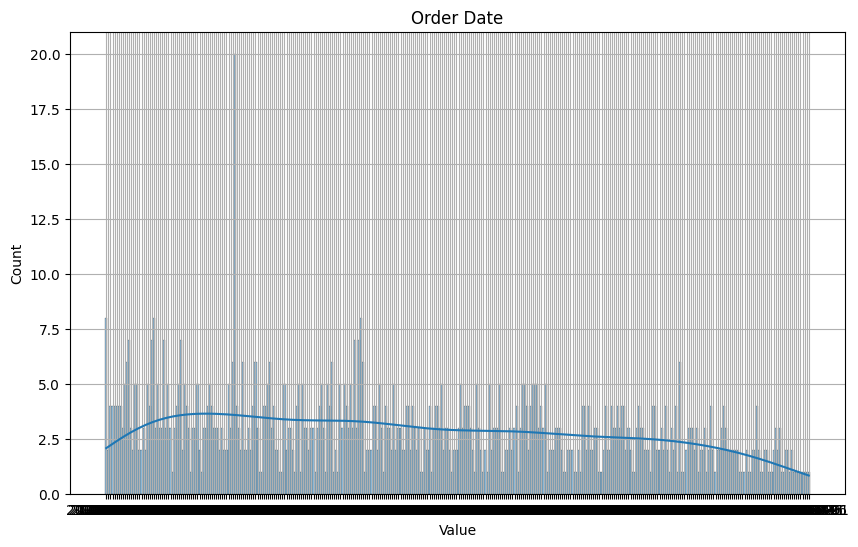

In [4]:
for column in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True, bins=10)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()


Categorical variables (Gender, Region, Category, and Shipping Status) are encoded using one-hot encoding to create binary columns. Numerical columns (Unit Price, Quantity, Total Price, Shipping Fee, and Age) are normalized with StandardScaler, ensuring consistent scales for clustering.

In [5]:
# Handle missing values - Filling missing Age values with the mean age
data['Age'] = data['Age'].fillna(data['Age'].mean())

# Encode categorical columns
encoded_data = pd.get_dummies(data, columns=['Gender', 'Region', 'Category', 'Shipping Status'], drop_first=True)

# Normalize numerical columns (Unit Price, Quantity, Total Price, Shipping Fee, Age)
columns_to_scale = ['Unit Price', 'Quantity', 'Total Price', 'Shipping Fee', 'Age']
scaler = StandardScaler()
encoded_data[columns_to_scale] = scaler.fit_transform(encoded_data[columns_to_scale])

# Select relevant features for clustering
features = encoded_data[columns_to_scale + [col for col in encoded_data.columns if col.startswith(('Gender_', 'Region_', 'Category_', 'Shipping Status_'))]]

# Display the cleaned and preprocessed data
dataframe=features

features.head()

,Unit Price,Quantity,Total Price,Shipping Fee,Age,Gender_Male,Region_North,Region_South,Region_West,Category_Electronics,Category_Wearables,Shipping Status_In Transit,Shipping Status_Returned
0,-0.293696,1.419264,0.083682,0.202634,0.000000,True,True,False,False,True,False,False,True
1,-0.666161,-0.718182,-0.625491,-1.244085,-1.735073,True,False,False,True,False,False,True,False
2,-0.293696,-1.430664,-0.570939,-0.250883,0.513199,False,False,True,False,True,False,False,True
3,-0.666161,1.419264,-0.461835,-0.044533,-1.664814,True,True,False,False,False,False,False,False
4,1.941096,-0.005700,1.720236,-1.591026,0.000000,False,False,True,False,True,False,False,False


In [6]:
# Example: Ensure only numeric columns are used
numeric_data = data.select_dtypes(include=[np.number])  # Select only numeric columns

# Standardize the numeric data
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA to find the number of components with explained variance > 0.1
pca = PCA(n_components=None)
dfx_pca = pca.fit(scaled_data)
explained_variance_ratio = dfx_pca.explained_variance_ratio_

# Find the number of components where explained variance > 0.1
n_components = sum(explained_variance_ratio > 0.1)

# Reapply PCA with the determined number of components
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(scaled_data)

print("Number of Components Selected:", n_components)

Number of Components Selected: 4


In [14]:
kmeans= KMeans(n_init='auto')
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6],  # Testing different cluster numbers
    'init': ['k-means++', 'random'],  # Initialization methods
    'max_iter': [300, 500],  # Iterations
    'random_state': [42]  # Consistent results
}
grid_search = GridSearchCV(kmeans, param_grid, cv=10,n_jobs=32)
grid_search.fit(scaled_data)
print('best inertia is: '+str(grid_search.best_score_))
print('best parameter is: '+str(grid_search.best_params_))

best inertia is: -207.0299730530854
best parameter is: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 6, 'random_state': 42}


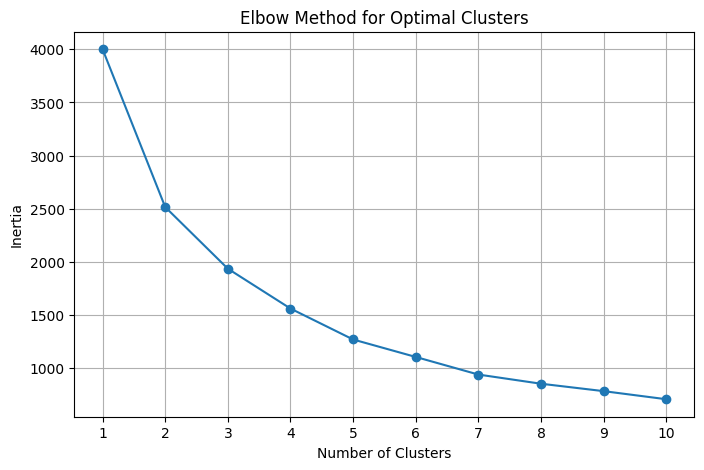

In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['Age', 'Unit Price', 'Quantity', 'Total Price']])

# Run KMeans for a range of cluster numbers and calculate inertia
inertia = []
cluster_range = range(1, 11)  # Test 1 to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method chart
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid()
plt.show()


The plot displayed is the Elbow Method chart, which helps determine the optimal number of clusters for the KMeans algorithm.
From 1 clusters to 3 clusters, the inertia rapidly drops, suggesting a notable improvement in the quality of the clustering. After four clusters, though, the pace of decline slows and forms a "elbow" after that. This implies that **4 clusters** strike the ideal balance between simplicity and compactness for this dataset. The benefits of adding clusters decrease beyond 4. The right number of clusters for additional investigation is chosen based on this realization. 

### Ploting KMeans Clustering in 3D PCA Space

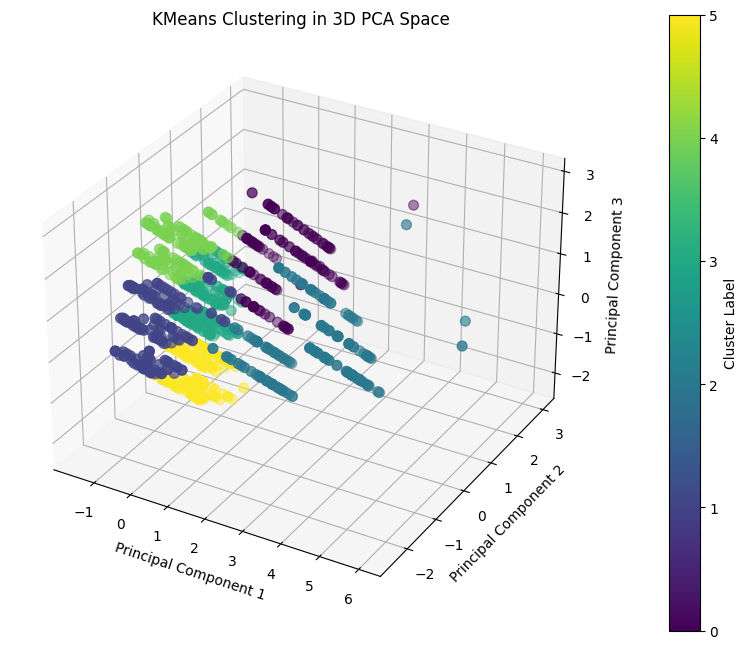

In [10]:
# Step 1: Reduce to 3 components for visualization
pca = PCA(n_components=3)  # Reduce to 3 dimensions
pca_features = pca.fit_transform(scaled_features)

# Step 2: Apply KMeans
kmeans = KMeans(n_clusters=6, random_state=42)  # Choose number of clusters
kmeans_labels = kmeans.fit_predict(pca_features)

# Add cluster labels to the dataset
data['PCA_KMeans_Cluster'] = kmeans_labels

# Step 3: Visualize the clusters in 3D PCA space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with cluster labels as colors
scatter = ax.scatter(
    pca_features[:, 0],  # PC1
    pca_features[:, 1],  # PC2
    pca_features[:, 2],  # PC3
    c=kmeans_labels,
    cmap='viridis',
    s=50
)

# Add labels and title
ax.set_title('KMeans Clustering in 3D PCA Space')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add color bar
colorbar = plt.colorbar(scatter, ax=ax, pad=0.1)
colorbar.set_label('Cluster Label')

plt.show()


The 3D scatter graphic displays the results of **KMeans clustering** on a dataset reduced to three principal components via **PCA**. The axes represent the three principal components (PC1, PC2, and PC3), with each point symbolizing a data sample. The colors signify the cluster assignments determined by the KMeans algorithm.

The graphic effectively differentiates the clusters, showing that the PCA has preserved the data's structure. The distinct clusters, such as yellow, purple, and green, represent groups of data points sharing similar patterns or characteristics. This clustering can be utilized for customer segmentation, identifying behavioral groups, and deriving actionable insights.

In [12]:
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame for clarity
variance_contributions = pd.DataFrame({
    'Principal Component': ['PC1', 'PC2', 'PC3'],
    'Explained Variance Ratio': explained_variance_ratio
})

# Add cumulative explained variance
variance_contributions['Cumulative Variance'] = variance_contributions['Explained Variance Ratio'].cumsum()

variance_contributions

,Principal Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.476358,0.476358
1,PC2,0.251450,0.727808
2,PC3,0.246969,0.974777


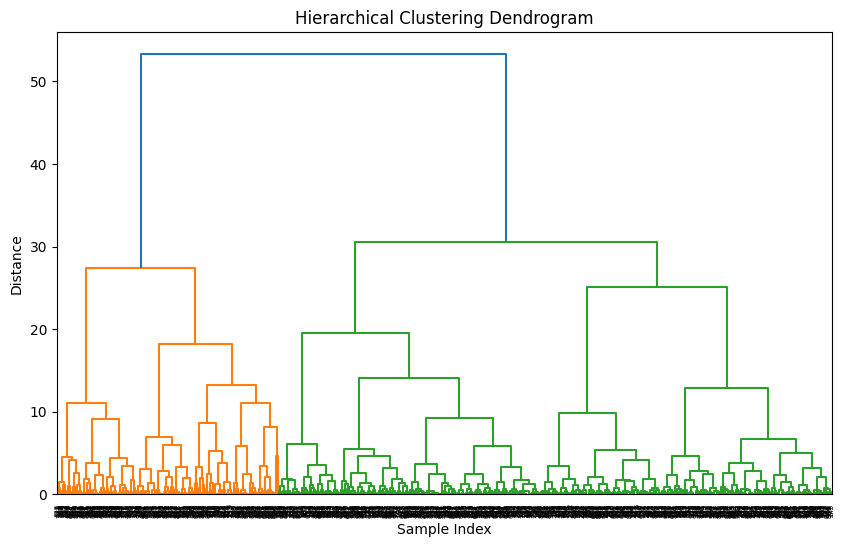

In [13]:
# Compute the linkage matrix
linkage_matrix = linkage(scaled_features, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Cut the dendrogram at a specified distance to form clusters
hierarchical_clusters = fcluster(linkage_matrix, t=4, criterion='maxclust')  # Adjust 't' as needed
data['Hierarchical Cluster'] = hierarchical_clusters

# --- DBSCAN Clustering ---
# Initialize DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(scaled_features)

# Add DBSCAN cluster labels to the dataset
data['DBSCAN Cluster'] = dbscan_labels


               Age              Unit Price              Total Price  \
              mean        std         mean         std         mean   
Cluster                                                               
1        48.698073  13.645960  1208.438949  416.062579  3639.160839   
2        45.893427  14.402831   156.989128  136.249777   428.291317   

                      Quantity            
                 std      mean       std  
Cluster                                   
1        2006.429489  3.129371  1.424366  
2         388.674367  2.959384  1.394148  


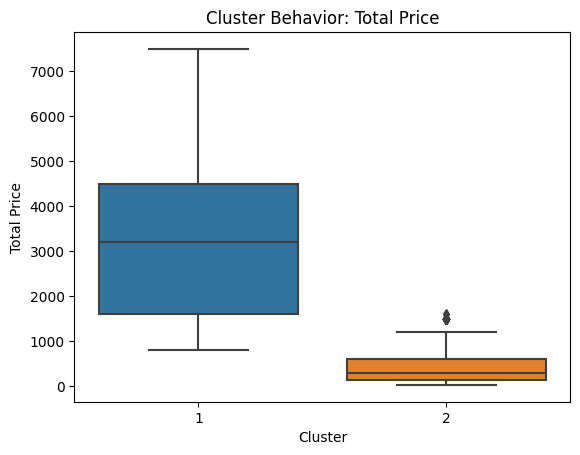

Cluster  Category   
1        Electronics    1.000000
2        Accessories    0.561625
         Electronics    0.267507
         Wearables      0.170868
Name: proportion, dtype: float64


In [18]:
cluster_labels = fcluster(linkage_matrix, t=2, criterion='maxclust')
data['Cluster'] = cluster_labels
cluster_summary = data.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Unit Price': ['mean', 'std'],
    'Total Price': ['mean', 'std'],
    'Quantity': ['mean', 'std']
})
print(cluster_summary)
sns.boxplot(x='Cluster', y='Total Price', data=data)
plt.title('Cluster Behavior: Total Price')
plt.show()
category_distribution = data.groupby('Cluster')['Category'].value_counts(normalize=True)
print(category_distribution)

# Conclusion
This Hierarchical Clustering Dendrogram visually represents the hierarchical grouping of data points based on their similarities. Each merge in the dendrogram corresponds to a cluster formation at a certain distance threshold (y-axis).The results highlight the distinct behaviors of two customer clusters. Customers in Cluster 1 are older (mean age: 48.69), like expensive goods, and only buy electronics, which have an average unit price of 1028.43. With an average total price of 3639.16 and sporadic huge outliers up to 7000, their transactions are substantially greater. Younger, cost-conscious consumers (mean age: 45.89) who prioritize accessories (56%), electronics (27.5%), and wearables (17%) are represented by Cluster 2. With an average unit price of 156.99 and a total price of 428.29, their transactions are smaller. Cluster 2 benefits from sales-boosting discounts and promotions, whereas Cluster 1 is best suited for targeting premium products.

### where I can Improvement
consider incorporating additional features such as purchase frequency, total spending trends, or time-based metrics like recency. Analyzing temporal patterns, such as seasonal behaviors, can provide richer insights into customer habits. Experimenting with different clustering algorithms, such as DBSCAN or Gaussian Mixture Models (GMM), and validating performance with metrics like Silhouette Score or Davies-Bouldin Index will ensure robust cluster formation. Improved visualizations, such as pair plots or t-SNE projections, can help interpret cluster behavior more effectively. Additionally, refining category-level analysis, addressing outliers, and combining demographic features with spending patterns can lead to more meaningful segmentation. Finally, leveraging these clusters for targeted marketing, loyalty programs, and predictive modeling will maximize actionable business insights.

